# Computing the forward model

`
Authors: Britta Westner, Eric Larson, Denis Engemann, Alex Gramfort
`

The aim of this lecture is to show you how to compute a forward model. This is a necessary ingredient for source reconstruction methods.

In [3]:
# %matplotlib qt
import matplotlib.pyplot as plt

import os
import mne

# Change the following path to where the ds000117 and the extra folder are on your disk
# data_path = os.path.expanduser("~/Documents/teaching/2023_berlin_brains/BerlinBrains2023DataPackage/")
data_path = os.path.expanduser("C:/Users/mahta/OneDrive/Documents/Work/Codes/IFT6168/TCL/data")
# We load the epochs to get access to epochs.info
epochs_fname = os.path.join(data_path, 'RestingState_epo.fif')
epochs = mne.read_epochs(epochs_fname)

Reading C:\Users\mahta\OneDrive\Documents\Work\Codes\IFT6168\TCL\data\RestingState_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated


# Computing the forward operator

To compute a forward operator (also known as forward model, gain matrix, or - less accurately - lead field) we need:

   - a ``-trans.fif`` file that contains the coregistration information
   - a source space
   - the BEM surfaces

## Compute Boundary Element Models (BEM) surfaces


Here, we work with **pre-computed BEM surfaces**. 

Computing the BEM surfaces requires _FreeSurfer_ (get it at: https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall#Download) and makes use of either of the two following command line tools:

[mne watershed_bem](http://martinos.org/mne/dev/generated/commands.html#mne-watershed-bem)

[mne flash_bem](http://martinos.org/mne/dev/generated/commands.html#mne-flash-bem)

It can also be done by directly calling the functions from a script (FreeSurfer installation needed):

https://mne.tools/stable/generated/mne.bem.make_watershed_bem.html

https://mne.tools/stable/generated/mne.bem.make_flash_bem.html



### Re-computing the BEM surfaces yourself

If you would like to try out BEM reconstruction for yourself later, you can install FreeSurfer on MacOS or Linux directly and in a VirtualMachine for Windows. 

To compute BEM segmentations for this dataset, you set up the `SUBJECTS_DIR` and run:

    mne watershed_bem -s sub-02 --overwrite
    mne make_scalp_surfaces -s sub-02 --force --overwrite


## Visualize the MRI and derived BEM surfaces

Now, let's first look at the BEM surfaces.

For EEG we use 3 layers (inner skull, outer skull, and skin), while for MEG 1 layer (inner skull) is enough.


In [4]:
# first set the path to the T1
# t1_fname = os.path.join(data_path, 'freesurfer/sub-02/mri/T1.mgz')
# We have multiple T1-weighted MRI scans with different acquisition protocols (HCP, VNavNorm, VNav).
# This one is chosen based on no particular reason other that HPC being generally cool.
t1_fname = os.path.join(data_path, 'sub-NDAREM687HPE/anat/sub-NDAREM687HPE_acq-HCP_T1w.nii.gz')

We can have a look at the MRI using `nilearn`:

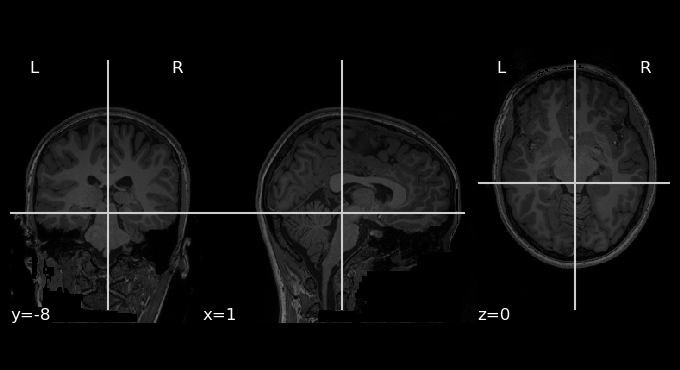

In [5]:
%matplotlib inline
from nilearn import plotting
plotting.plot_anat(t1_fname);
plt.show()

We can also look at the BEM model (the identified surfaces of the BEM):

Using surface: C:\Users\mahta\OneDrive\Documents\Work\Codes\IFT6168\MNE_SR\data\freesurfer\sub-02\bem\inner_skull.surf
Using surface: C:\Users\mahta\OneDrive\Documents\Work\Codes\IFT6168\MNE_SR\data\freesurfer\sub-02\bem\outer_skull.surf
Using surface: C:\Users\mahta\OneDrive\Documents\Work\Codes\IFT6168\MNE_SR\data\freesurfer\sub-02\bem\outer_skin.surf


c:\Users\mahta\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


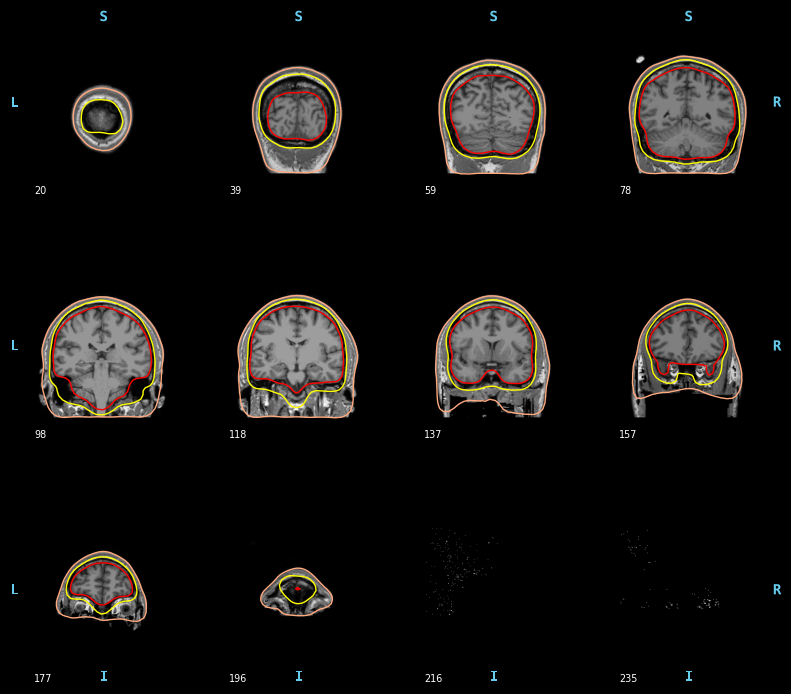

In [ ]:
# This is the path that point to the directory that has the subject folder(s) for the BEM models.
# Here, it is the path that you saved the extra data at.
subjects_dir = os.path.join(data_path, 'freesurfer')

# plot the BEM
%matplotlib inline
mne.viz.plot_bem(subject='sub-02', subjects_dir=subjects_dir,
                 mri=t1_fname,
                 orientation='coronal');

## Coregistration 

The next step usually would be to coregister the MRI coordinate system with the MEG coordinate system. This is done to get the sensors into the right relation to the head model for the forward model computation.

In the MNE software, the transformation to align the head and the sensors in stored in a so called *trans* file. It is a FIF file that ends with `-trans.fif`. It can be obtained with ``mne_analyze`` (Unix tools), ``mne.gui.coregistration`` (see below) or ``mrilab`` if you're using a Neuromag system.

For this data set that's already done, but if you wanted to do this on your own again, below is the code to use.
There is information on how to do this on the MNE-Python homepage in the [Source alignment tutorial, part "Defining the head to MRI `trans` using the GUI"](https://mne.tools/stable/auto_tutorials/forward/20_source_alignment.html#defining-the-headmri-trans-using-the-gui), including a link to a video that walks you through it.

In [ ]:
# mne.gui.coregistration(subject='sub-02', subjects_dir=subjects_dir, inst=epochs_fname);

### Visualizing the coregistration

Since we assume the coregistration is done, we just visually check the alignment between head surface and sensors with the following code.

In [ ]:
trans_fname = os.path.join(data_path, 'freesurfer/sub-02/bem/sub-02-trans.fif')

fig = mne.viz.plot_alignment(epochs.info, trans_fname, subject='sub-02', dig=True,
                             subjects_dir=subjects_dir, verbose=True);

Using pyvistaqt 3d backend.

Using outer_skin.surf for head surface.
Getting helmet for system 306m
Channel types::	grad: 204, mag: 102


## Compute the source space

The source space defines the positions of the candidate source locations. The following code computes such a source space with an OCT-6 resolution. 

Note that this is a surface (not volume) source space.

In [ ]:
mne.set_log_level('WARNING')
subject = 'sub-02'
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir,
                             add_dist=False)

In [ ]:
src

<SourceSpaces: [<surface (lh), n_vertices=138973, n_used=4098>, <surface (rh), n_vertices=139663, n_used=4098>] MRI (surface RAS) coords, subject 'sub-02', ~20.4 MB>


We can visualize the source space together with the head model and also together with the MEG helmet.

In [ ]:
%matplotlib inline
mne.viz.plot_alignment(epochs.info, trans_fname, subject=subject, dig=False, src=src,
                            subjects_dir=subjects_dir, verbose=True, meg=False,
                            eeg=False);

Using outer_skin.surf for head surface.


In [ ]:
mne.viz.plot_alignment(epochs.info, trans_fname, subject=subject,
                       src=src, subjects_dir=subjects_dir, dig=True,
                       surfaces='white', coord_frame='meg')

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Query the length of src - can you explain the number you get? </li>
    </ul>
</div>

## Compute the BEM solution

Now we can compute the final BEM head model from the BEM surfaces. 

To reduce computational load, we'll only compute a _single layer BEM_ (i.e., only layer is the inner skull) that can then be used for MEG (but not EEG).

Let's compute the BEM model using `mne.make_bem_solution()`, then we compute the forward solution using `mne.make_forward_solution()`.

In [ ]:
conductivity = (0.3,)  # for single layer
# conductivity = (0.3, 0.006, 0.3)  # this could be used for three layers
model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

We can write this solution to disk for later use:

In [ ]:
bem_fname = os.path.join(data_path,
    'freesurfer/sub-02/sub-02-bem.fif')
mne.bem.write_bem_solution(bem_fname, bem, overwrite=True)

## Compute the forward model

Now we have all the ingredients to compute the forward solution. So let's do that (this might take a while!):

In [ ]:
fwd = mne.make_forward_solution(epochs.info, trans=trans_fname,
                                src=src, bem=bem,
                                meg=True,  # include MEG channels
                                eeg=False,  # exclude EEG channels
                                mindist=5.0,  # ignore sources <= 5mm from inner skull
                                n_jobs=1)  # number of jobs to run in parallel

In [ ]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 306 sensors x 21711 dipoles


We also save the forward model for use in our source reconstruction tutorial:

In [ ]:
fwd_fname = os.path.join(data_path, 'sub-02/sub-02-meg-fwd.fif')
mne.write_forward_solution(fwd_fname, fwd, overwrite=True)

## Bonus episode: Compute and show sensitivity maps

Let's compute a sensitivity map for gradiometers, we asked for the dipole orientation to be fixed.

In [ ]:
sens_map = mne.sensitivity_map(fwd, ch_type='grad', mode='fixed')

Let's view in 3D:

In [ ]:
# enable correct backend for 3d plotting
clim = dict(kind='percent', lims=(0.0, 50, 99), smoothing_steps=3)  # let's see single dipoles
brain = sens_map.plot(subject=subject, time_label='GRAD sensitivity',
                      subjects_dir=subjects_dir, clim=clim, smoothing_steps=8);
view = 'lat'
brain.show_view(view)


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compute and plot the sensitivity maps for magnetometers and compare it with the gradiometers. </li>
      <li>Can you justify the claims that MEG is not sensitive to radial sources?</li>     
      <li>Try changing the `mode` parameter in `mne.sensitivity_map` and see how fixed or free orientation forward operator change the pictures. Comment.</li>
    </ul>
</div>